# <center>Optimisation combinatoire par métaheuristique <br /> Workshop</center>

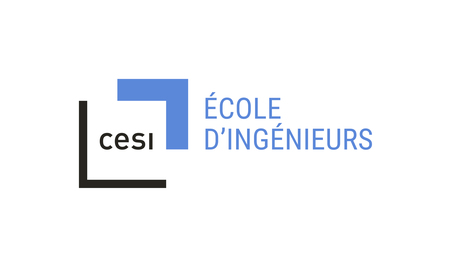


Nous retrouvons notre étudiant et son Smartphone plein à craquer. Il n'a pas renoncé à emmener sa bibliothèque musicale avec lui, mais sa tentative de s'appuyer sur le problème du [sac à dos](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_sac_%C3%A0_dos) n'a pas été très concluante. L'approche par programmation linéaire n'a pas fonctionné, du fait des variables en nombre entier, qui rendent sa résolution par le Simplexe impossible. C'est dommage, parce que ce problème algorithmique correspond à de nombreux challenges, notamment issus de la logistique. Lesquels pouvez-vous imaginer&nbsp;?

Les challenges de logistique qui correspondent au problème du sac à dos incluent : le chargement de véhicules (camions, avions, navires) en maximisant la valeur tout en respectant des contraintes de capacité, la gestion des stocks, le chargement de palettes, l'optimisation de la distribution, et l'allocation de ressources limitées pour des projets à maximiser le retour sur investissement.

# 1 Modélisation et implémentation de base

Nous allons déjà commencer par mettre en place une approche générique simple pour résoudre ce problème du sac à dos.


## 1.1 Modélisation heuristique

L'algorithme [_Hill Climbing_](https://fr.wikipedia.org/wiki/M%C3%A9thode_hill-climbing) (qu'on ferait parfois mieux d'appeler _Valley Descending_) est une solution assez simple à implémenter. En quoi consiste cet algorithme&nbsp;?

Le Hill Climbing est une méthode de recherche locale qui part d'une solution initiale et améliore progressivement cette solution en explorant son voisinage. À chaque étape, on sélectionne le voisin qui améliore le plus la solution actuelle, jusqu'à atteindre un optimum local où aucun voisin n'est meilleur.


La première (et la principale) étape de la modélisation d'un problème pour une méta-heuristique est donc la définition de la structure de voisinage (du moins dans le cas d'une méthode par trajectoire). Quelle modification simple d'une solution peut-on considérer dans notre cas de problème de sac à dos&nbsp;?

Pour le sac à dos, le voisinage d'une solution peut être défini en basculant l'état (présent/absent) d'un seul objet à la fois. Cela signifie que chaque voisin est obtenu en ajoutant ou en retirant un unique objet du sac.

Reste à traiter la question de la représentation informatique de nos données. Sachant qu'une solution représente, pour chaque objet, le fait qu'on prenne ou non cet objet, comment va-t-on modéliser informatiquement une telle solution&nbsp;?

Une solution peut être représentée comme un tuple de booléens, où chaque position i contient True si l'objet i est dans le sac, et False sinon.

À partir de là, représenter les poids et valeurs de chaque objet est assez naturel. Quelles structures seront adaptées&nbsp;?

Des tuples ou des dictionnaires pour stocker les poids et valeurs de chaque objet. Les tuples offrent une meilleure performance pour l'accès aux éléments.

## 1.2 Structures et fonctions de base


Vous connaissez déjà le principe très général des algorithmes qu'on va implémenter. Il s'agit de générer des solutions valides, d'en évaluer la valeur, et de garder la meilleure. Quelles structures de données Python allons-nous utiliser pour privilégier les performances à l'exécution&nbsp;? Proposez une structure pour&nbsp;:
* une instance du problème
* une solution d'une instance

Pour l'instance, un tuple de deux tuples contenant les poids et valeurs de chaque objet. Pour la solution, un tuple de booléens où chaque position représente si l'objet est inclus ou non.

Commençons par nous occuper des instances. Si on veut tester nos fonctions, il faut pouvoir générer aléatoirement une instance (étant donnés un poids et une valeur maximale pour tout objet). Pour le nombre d'objets et la capacité du sac, deux entiers feront l'affaire&nbsp;:

In [17]:
nb_objets = 10
capacite = 20

Avec la bibliothèque standard [random](https://docs.python.org/fr/3/library/random.html) de Python, notre fonction de génération d'instance aléatoire sera très simple à écrire. Elle pourra renvoyer un tuple de dictionnaires `(poids, valeur)`, qu'elle aura générés avec des Comprehension. 

In [18]:
import random

def random_objets(poids_max, val_max):
    """
    Cette fonction genere des objets de poids et de valeur
    aleatoires (borne par les valeurs passees en parametre).
    
    Renvoie un tuple de 2 dictionnaires (poids,valeur)
    """

    poids_objets = tuple(random.randint(1, poids_max) for _ in range(nb_objets))
    valeur_objets = tuple(random.randint(1, val_max) for _ in range(nb_objets))
    
    return poids_objets, valeur_objets

random.seed(a=3) # utiliser un seed explicitement permettra de reproduire les conditions initiales
                 # et de comparer le comportement de différents algorithmes sur une même instance

poids_objets, valeur_objets = random_objets(10, 10)
print(str(poids_objets) + "\n" + str(valeur_objets))

(4, 10, 9, 3, 6, 10, 8, 10, 2, 10)
(1, 8, 5, 9, 4, 4, 8, 9, 9, 8)


Maintenant que nous pouvons générer une instance aléatoire, on va pouvoir implémenter et tester les fonctions de base dont toute métaheuristique a besoin. Les fonctions essentielles incluent : une fonction pour évaluer la validité d'une solution (vérifier que le poids ne dépasse pas la capacité), une fonction pour calculer la valeur totale d'une solution, une fonction pour générer des voisins d'une solution donnée, et une fonction pour évaluer la qualité d'une solution.

Ce qu'il faudrait donc, c'est arriver à écrire une Comprehension qui renvoie les indices des objets présents dans le sac. Pour ça, on va ajouter une [List Comprehension conditionnelle](https://riptutorial.com/python/example/767/conditional-list-comprehensions), qui va [énumérer](https://www.guru99.com/python-enumerate-function.html) le contenu du sac, et filtrer uniquement les valeurs <code class="cm-s-ipython language-python"><span class="cm-keyword">True</span></code>. Essayons déjà d'écrire cette Comprehension.



In [19]:
sac = (True, False, True)

# on teste le générateur avec un List Comprehension
objets = [i for i, val in enumerate(sac) if val]

print(objets)

[0, 2]


On obtient bien la liste des indices des objets qui nous intéressent. Maintenant, on va modifier ce générateur pour créer la liste des valeurs de poids des objets présents dans le sac.


On va directement utiliser cette méthode pour implémenter fonction de calcul du poids du sac. Et au passage, on implémente aussi le calcul de la valeur du sac, sur le même principe.

In [20]:
def poids_contenu(sac):
    """
    Cette fonction renvoie la somme des poids des objets dans le sac
    """
    # somme des poids des objets présents dans le sac
    return sum(poids_objets[i] for i, val in enumerate(sac) if val)

def valeur_contenu(sac):
    """
    Cette fonction renvoie la somme des valeurs des objets dans le sac
    """
    # somme des valeurs des objets présents dans le sac
    return sum(valeur_objets[i] for i, val in enumerate(sac) if val)


Tout fonctionne correctement&nbsp;? Pour le vérifier, le plus simple est de générer une solution aléatoire, et de tester nos deux fonctions sur cette solution. 

In [21]:
import random

random.seed(a=3)
nb_objets = 5
poids_objets, valeur_objets = random_objets(10, 10)

test = tuple(random.choice([False, True]) for _ in range(nb_objets))
for o in range(nb_objets):
    print("%d:(%d,%d) "%(o, poids_objets[o], valeur_objets[o]), end='')

print("")
print([i for i, val in enumerate(test) if val]) # affiche les indices des valeurs True de la solution
print("poids=%d, valeur=%d" %(poids_contenu(test), valeur_contenu(test)))

0:(4,10) 1:(10,8) 2:(9,10) 3:(3,2) 4:(6,10) 
[1, 2]
poids=19, valeur=18


Apparemment, ça marche&nbsp;!



# 2 Heuristique simple
Nous pouvons maintenant nous lancer dans l'implémentation d'un _Hill Climbing_. Pour commencer, il faut implémenter la fonction de calcul de voisinage d'une solution dont on a parlé plus haut. 

## 2.1 Génération de voisinage
Nous voulons donc générer l'ensemble de tous les voisins d'une solution (donc d'un tuple de booléens). Pour être sûr de vous, écrivez cet algorithme de manière plus détaillée. Vous pouvez considérer qu'une fonction de clonage d'une solution est à votre disposition.

Algorithme détaillé :
1. Pour chaque indice k du 0 à la longueur du sac
2. Créer un nouveau sac en inversant l'état (True/False) de l'objet à l'indice k
3. Retourner ce nouveau sac comme voisin

Maintenant, reste à implémenter cet algorithme.


In [22]:
def voisinage(sac):
    """
    Cette fonction est un générateur de tous les voisins valides d'une solution
    """
    for k in range(len(sac)):
        # un indice : on veut les états des k-1 premiers objets et des |sac|-k-1 derniers objets
        # et l'état inverse de l'objet k (attention aux bornes du slicing)
        yield sac[:k] + (not sac[k],) + sac[k+1:]

# on teste
test = (True, False, True)
print (test, "\nvoisins :")
for voisin in voisinage(test):
    print(voisin)

(True, False, True) 
voisins :
(False, False, True)
(True, True, True)
(True, False, False)


Cela vous parait-il bon&nbsp;? Pourquoi n'y a-t-il pas plus de solutions&nbsp;?

Parce que nous n'inversons que l'état d'un seul objet à la fois. Pour une solution de taille n, il y a exactement n voisins possibles (chaque voisin correspond à l'inversion d'un objet différent). Le voisinage est donc de taille n.


## 2.2 Hill Climbing


Nous pouvons enfin nous lancer dans l'implémentation de notre heuristique _Hill Climbing_. Si on devait écrire l'algorithme de manière plus détaillée, que pourrait-on proposer&nbsp;?

1. Commencer avec une solution initiale
2. Évaluer la solution courante
3. Générer et évaluer tous les voisins
4. Si un voisin a une meilleure valeur, le devenir la nouvelle solution courante et répéter à l'étape 3
5. Si aucun voisin n'est meilleur, s'arrêter (convergence sur un optimum local)

Quel défaut a cet algorithme&nbsp;? Comment pourrait-on y remédier&nbsp;?

L'algorithme converge vers un optimum local qui peut être très éloigné de l'optimum global. On peut y remédier en utilisant une approche multi-start qui teste plusieurs solutions initiales différentes, ou en utilisant une métaheuristique plus sophistiquée comme la recherche tabou, le recuit simulé ou les algorithmes génétiques qui permettent d'accepter des solutions moins bonnes pour éviter les optima locaux.

Lançons-nous maintenant dans son implémentation&nbsp;!

In [23]:
def hill_climbing(solution_initiale):
    """
    1. On part d'un élément de notre ensemble de recherche qu'on déclare élément courant
    2. On considere le voisinage de l'élément courant et on choisit le  meilleur d'entre
       eux comme nouvel élément courant
    3. On boucle jusqu'à convergence sur un optimum local
    """

    solution_courante = solution_initiale
    nouveau = True
    nb_iter = 0 # uniquement utilisé pour l'affichage
    
    while (nouveau):
        nb_iter += 1
        
        # on parcourt tous les voisins de la solution courante pour garder la meilleure
        meilleure_solution = solution_courante
        meilleure_valeur = valeur_contenu(solution_courante)
        
        for voisin in voisinage(solution_courante):
            if poids_contenu(voisin) <= capacite:
                valeur_voisin = valeur_contenu(voisin)
                if valeur_voisin > meilleure_valeur:
                    meilleure_solution = voisin
                    meilleure_valeur = valeur_voisin
        
        nouveau = (meilleure_solution != solution_courante)
        solution_courante = meilleure_solution
    
    return solution_courante

## 2.3 Exécution de l'heuristique
Testons cet algorithme en prenant comme solution initiale un sac vide, et affichons la solution proposée&nbsp;:

In [24]:
random.seed(a=3)
capacite = 20
nb_objets = 100
poids_objets, valeur_objets=random_objets(10, 10)

sac = (False,)*nb_objets # une fonctionnalité utile en Python

print("optimisation locale")
sol = hill_climbing(sac)
print("valeur finale = " + str(valeur_contenu(sol)) + ", capacite=" + str(poids_contenu(sol)) + "/" + str(capacite))
print([i for i, val in enumerate(sol) if val]) # liste des objets dans le sac

optimisation locale
valeur finale = 30, capacite=20/20
[5, 11, 27]


Trois objets, ce n'est pas beaucoup&nbsp;!! Ceci dit, on peut peut-être faire quelque chose pour améliorer ça. Réfléchissez&nbsp;: cet algorithme est [déterministe](https://fr.wikipedia.org/wiki/Algorithme_d%C3%A9terministe). Lorsqu'on considère un algorithme d'optimisation comme la recherche tabou, qu'est-ce que ça implique en termes de qualité de solution pour une instance donnée&nbsp;?

Cela signifie que pour une instance donnée et une solution initiale, on obtient toujours le même résultat (le même optimum local). La qualité de la solution dépend de la solution initiale et on peut se retrouver coincé dans un optimum local non optimal.

Ça ne vous donne pas une idée pour améliorer le résultat produit par l'algorithme&nbsp;? Comment pourrait-on implémenter une telle approche&nbsp;?

On peut essayer plusieurs solutions initiales différentes et conserver la meilleure solution trouvée. Cette approche s'appelle le multi-start. Cela permet d'explorer différentes régions de l'espace de recherche et d'augmenter les chances de trouver une meilleure solution.

C'est simple à mettre en place, surtout en Python. Quelle fonction devez-vous implémenter&nbsp;? Que fera-t-elle exactement&nbsp;? Un indice, les fonctions de génération aléatoire de Python, par exemple [<code class="cm-s-ipython language-python"><span class="cm-builtin">random_choice</span></code></a>](https://docs.python.org/3/library/random.html#random.choice) devraient vous être utiles.

Une fonction qui génère une solution aléatoire valide (respectant la contrainte de capacité). Elle créera un tuple de booléens aléatoires, puis supprimera aléatoirement des objets jusqu'à respecter la contrainte de capacité.

Allons-y&nbsp;!


In [25]:
def random_solution():
    sac = tuple(random.choice([False, True]) for _ in range(nb_objets))

    while (poids_contenu(sac) > capacite):
        # liste des indices de valeur `True` dans le sac
        objets_presents = tuple(i for i, val in enumerate(sac) if val)
        
        # choix aléatoire d'un objet à supprimer parmi ceux présents dans le sac
        objet_supprime = random.choice(objets_presents)
        
        # suppression de l'objet sélectionné aléatoirement
        sac = sac[:objet_supprime] + (False,) + sac[objet_supprime+1:]

    return sac

Il ne nous reste plus qu'à tester tout ça. Pour commencer, essayons avec 10 itérations. À chaque itération, affichez le résultat de la recherche (comme l'affichage final l.14 du code à compléter, mais sans afficher le détail de la solution), qu'on puisse voir un peu ce qui se passe.

In [26]:
val_max = 0
sol_max = None
for _ in range(5):
    sol = hill_climbing(random_solution())
    val = valeur_contenu(sol)
    print("valeur = %d, capacite=%d/%d" % (val, poids_contenu(sol), capacite))
    if val > val_max:
        val_max = val
        sol_max = sol

print("\nvaleur finale = %d, capacite=%d/%d\n" % (val_max, poids_contenu(sol_max),capacite))
print([i for i, val in enumerate(sol_max) if val])

valeur = 40, capacite=20/20
valeur = 28, capacite=20/20
valeur = 33, capacite=20/20
valeur = 40, capacite=20/20
valeur = 44, capacite=20/20

valeur finale = 44, capacite=20/20

[1, 27, 41, 62, 76, 81]


On a nettement amélioré le résultat&nbsp;! Et on constate effectivement que l'optimum local trouvé dépend de la solution de départ. En testant plusieurs solutions initiales, on améliore dans certains cas la solution trouvée. Comment s'appelle cette technique&nbsp;?

Cette technique s'appelle le **multi-start** ou **recherche multi-démarrage**.

C'est une métaheuristique qui combine une heuristique de base (ici le Hill Climbing) avec des essais multiples à partir de solutions initiales différentes pour augmenter les chances de trouver une bonne solution globale.


# 3 Méta-heuristiques
Finalement, on a déjà implémenté une première méta-heuristique, mais on ne va pas s'arrêter là&nbsp;!

## 3.1 Recherche avec liste tabou
Une métaheuristique un peu plus maligne qu'un Hill Climbing devrait donner de meilleurs résultats. Parmi toutes les métaheuristiques de la littérature, la méthode par [recherche avec liste tabou](https://fr.wikipedia.org/wiki/Recherche_tabou) (qu'on appelle souvent _méthode tabou_ par raccourcis) est celle qui pourrait être adaptée le plus facilement en partant du code du Hill Climbing. Pourquoi&nbsp;?

Parce que la structure générale est très similaire - on explore encore le voisinage - mais on ajoute un mécanisme pour éviter de revisiter les solutions déjà explorées. Cela permet de s'échapper des optima locaux.

De quelle structure de données algorithmique avons-nous besoin pour gérer ça&nbsp;?

Une queue (file) ou un ensemble pour stocker les solutions tabous (celles qu'on ne peut pas revisiter).

Pour implémenter ça en Python, quelle structure vous semble adaptée du point de vue des performances&nbsp;?

Une deque (double-ended queue) de la bibliothèque collections, qui permet d'ajouter/supprimer efficacement des éléments des deux extrémités et maintenir une taille fixe.

Cette fois, on a tout ce qu'il nous faut. Lançons-nous donc dans cette implémentation&nbsp;:

In [27]:
from collections import deque

def recherche_tabou(solution_initiale, taille_tabou, iter_max):
    """
    1. On part d'un élément de notre ensemble de recherche qu'on déclare élément courant
    2. On considère le voisinage de l'élément courant, on choisit le meilleur d'entre
       eux comme nouvel élément courant, parmi ceux absents de la liste tabou, et on l'ajoute
       à la liste tabou
    3. On boucle jusqu'à condition de sortie.
    """
    nb_iter = 0
    liste_tabou = deque(maxlen=taille_tabou)

    # variables solutions pour la recherche du voisin optimal non tabou
    solution_courante = solution_initiale
    meilleure = solution_initiale
    meilleure_globale = solution_initiale

    # variables valeurs pour la recherche du voisin optimal non tabou
    valeur_meilleure = valeur_contenu(solution_initiale)
    valeur_meilleure_globale = valeur_meilleure

    
    while (nb_iter < iter_max):
        valeur_meilleure = -1
        
        # on parcourt tous les voisins de la solution courante
        for voisin in voisinage(solution_courante):
            if poids_contenu(voisin) <= capacite and voisin not in liste_tabou:
                valeur_voisin = valeur_contenu(voisin)
                if valeur_voisin > valeur_meilleure:
                    meilleure = voisin
                    valeur_meilleure = valeur_voisin

        # on met à jour la meilleure solution rencontrée depuis le debut
        if valeur_meilleure > valeur_meilleure_globale:
            meilleure_globale = meilleure
            valeur_meilleure_globale = valeur_meilleure
            nb_iter = 0
        else:
            nb_iter += 1

        # on passe au meilleur voisin non tabou trouvé
        solution_courante = meilleure

        # on met à jour la liste tabou
        liste_tabou.append(solution_courante)

    return meilleure_globale

Un test avec une liste tabou de taille 5 sur la même instance que précédemment va nous permettre de comparer le résultat avec celui obtenu par optimisation locale&nbsp;:

In [28]:
nb_objets = 100
capacite = 20
random.seed(a=3)
poids_objets, valeur_objets = random_objets(10, 10)
sac = (False,)*nb_objets
taille_tabou=5
iter_max=30

print("tabou de taille 5")
sol=recherche_tabou(sac, taille_tabou, iter_max)
print("valeur finale = " + str(valeur_contenu(sol)) + ", capacite="+str(poids_contenu(sol)) + "/" + str(capacite))

tabou de taille 5
valeur finale = 62, capacite=20/20


On a nettement amélioré la qualité par rapport à la solution obtenue simplement par optimisation locale&nbsp;! C'est dire si cette première approche était inefficace… On est même meilleurs qu'avec le multi-start&nbsp;!

## 3.2 Tabou avec multi-start

D'ailleurs, on peut réutiliser ce principe du multi-start. Implémentez-le en renforçant la diversification (500 itérations, par exemple)&nbsp;:

In [29]:
random.seed(a=3)

sol_max = None
val_max = 0

for _ in range(500):
    sol = recherche_tabou(random_solution(), 5, 30)
    val = valeur_contenu(sol)
    if val > val_max:
        val_max = val
        sol_max = sol

print("valeur finale = " + str(valeur_contenu(sol_max)))

valeur finale = 89


La solution s'en trouve encore améliorée. Ceci dit, le surcoût en temps de calcul est conséquent.


Or, il y a un moyen d'accélérer les calculs sans toucher à grand chose. Certaines des fonctions qu'on a implémentées sont _pures_. Et ça, ça va nous permettre de mettre en place une accélération de l'exécution du code. Avez-vous une idée de comment faire&nbsp;?

Oui, on peut utiliser la mise en cache (caching) avec le décorateur `@lru_cache` pour les fonctions pures comme `poids_contenu` et `valeur_contenu`. Ces fonctions toujours retourner le même résultat pour les mêmes entrées, donc on peut mémoriser les résultats pour éviter les recalculs.

D'ailleurs, heureusement qu'on a choisi un tuple pour représenter une solution, car on n'aurait pas pu mettre en place cette technique avec des listes (qui ne sont pas hachables).

Avant tout, relançons le calcul en comptant le temps CPU, pour avoir une idée du gain qu'on obtiendra ensuite.


In [30]:
import time
random.seed(a=3)

sol_max = None
val_max = 0

start = time.process_time()

# multi-start de 500 itérations
for _ in range(500):
    sol = recherche_tabou(random_solution(), 5, 30)
    val = valeur_contenu(sol)
    if val > val_max:
        val_max = val
        sol_max = sol

stop = time.process_time()

print("valeur finale = " + str(valeur_contenu(sol_max)))
print("calculé en ", stop-start, 's')

valeur finale = 89
calculé en  10.015625 s


Testons maintenant cette technique, en redéfinissant les fonctions concernées.

In [31]:
from functools import lru_cache

@lru_cache(maxsize=None)
def poids_contenu_cached(sac):
    """
    Version en cache de poids_contenu
    """
    return sum(poids_objets[i] for i, val in enumerate(sac) if val)

@lru_cache(maxsize=None)
def valeur_contenu_cached(sac):
    """
    Version en cache de valeur_contenu
    """
    return sum(valeur_objets[i] for i, val in enumerate(sac) if val)

# Remplacer les références pour utiliser les versions en cache
poids_contenu = poids_contenu_cached
valeur_contenu = valeur_contenu_cached

Et testons ça en relançant le calcul précédent&nbsp;:

In [32]:
random.seed(a=3)

sol_max = None
val_max = -1

start = time.process_time()
# multi-start de 500 itérations
for _ in range(500):
    sol = recherche_tabou(random_solution(), 5, 30)
    val = valeur_contenu(sol)
    if val > val_max:
        val_max = val
        sol_max = sol

stop = time.process_time()

print("valeur finale = " + str(valeur_contenu(sol_max)))
print("calculé en ", stop-start, 's')

valeur finale = 89
calculé en  4.921875 s


L'accélération est impressionnante, le temps de calcul a été quasiment divisé par 4&nbsp;! Et plus on fera de calculs sur cette instance, plus on accélérera (en échange d'une consommation mémoire plus importante). Pour vous en convaincre, il suffit de relancer le même calcul, mais avec un seed différent&nbsp;:

In [33]:
#### Copiez-collez le code de la cellule précédente
random.seed(a=5)

sol_max = None
val_max = 0

start = time.process_time()
# multi-start de 500 itérations
for _ in range(500):
    sol = recherche_tabou(random_solution(), 5, 30)
    val = valeur_contenu(sol)
    if val > val_max:
        val_max = val
        sol_max = sol

stop = time.process_time()

print("valeur finale = " + str(valeur_contenu(sol_max)))
print("calculé en ", stop-start, 's')

valeur finale = 89
calculé en  5.09375 s


Là aussi, on est allés plus vite, alors que le scénario d'exécution n'est pas le même, ce qui signifie que les solutions initiales considérées sont différentes.


Et si vous vous demandez pourquoi on obtient malgré tout la même valeur de solution, on aura la réponse au prochain Workshop&nbsp;!

# 4. Conclusion

Ce Workshop est maintenant terminé, et on a enfin réussi à faire quelque chose de ce problème de sac à dos, puisque vous avez implémenté, non pas une, mais trois métaheuristiques, un Hill-Climbing avec multi-start, une recherche tabou simple, et une avec multi-start.


Même si vous partez sur une implémentation différente pour votre projet, vous voyez que ce n'est pas si compliqué. Prenons le cas d'un algorithme génétique. Dans le cas d'un sac à dos, que représenterait un gène&nbsp;?

Un gène représenterait l'état (présent ou absent) d'un seul objet dans le sac. Un chromosome complet serait un tuple de gènes représentant une solution complète.

Si on devait l'implémenter, on aurait déjà pas mal de fonctions réutilisables (génération aléatoire de solution, évaluation de la faisabilité d'une solution, de sa valeur). Il faudrait juste implémenter une fonction de croisement et une de mutation. Quel genre de croisement pourrait être envisagé&nbsp;?

Un croisement par point unique où on divise deux solutions parents à un point aléatoire et on combine les deux moitiés, ou un croisement uniforme où chaque gène du descendant est hérité aléatoirement d'un parent. Pour le sac à dos, on pourrait aussi faire un croisement où on combine les objets des deux parents.

Et pour la mutation&nbsp;?

La mutation pourrait inverser l'état (True/False) d'un nombre aléatoire d'objets, ou retirer/ajouter un objet aléatoire. Il faudrait aussi s'assurer que la solution mutée respecte la contrainte de capacité.

Une fois ces fonctions supplémentaires implémentées, le corps de l'algorithme ne sera pas tellement plus compliqué que celui de l'algorithme tabou qu'on vient d'écrire.


Mais la question qui se pose, c'est&nbsp;: est-ce que les solutions qu'on construit sont de bonne qualité&nbsp;? Finalement, on n'en sait rien. 

Il va bien falloir analyser le comportement de l'algorithme en fonction de certains paramètres, pour pouvoir déterminer s'il est efficace ou pas, et si nécessaire optimiser son fonctionnement. Et ça, c'est l'objet du prochain Workshop&nbsp;!